# CLASSIFICATION MODEL:
Due to nature of this process (creating a predictive model), involving coming back and forth trial and error while cleaning data and testing differet hyperparameters setup. We decided to:

- Move all our helper functions to a separated file, so we can reach them from every file while keeping our files cleaner.
- Have 2 code files to get our final model:
    - This file `clf_data_proccessing.ipynb`:<br>
        &emsp;To read and clean the data and save it to sql database in ``./database/models.db`` file.<br>
        &emsp;To test cleanliness of data, we'll use a random forest model.
    - Another file `clf_model_selection.ipynb` to test and compare different models working with cleaned dataset.
- Once final model version is selected, it will be serialized after trainning and stored in ``./trained_models`` folder.
- Then trained model will be deployed to a website built with flask/jinja to perform predictions for data entered by users.


In [4]:
from myFunc import *  # moved all our functions to separated file to keep this cleaner
# pulling dataset from UCI ML repository
heartDisease = fetch_ucirepo(id=45) 
df=heartDisease.data.original

In [5]:
#Connecting to database and saving a copy of raw data in it
con = sqlite3.connect('./../database/models.db')
df.to_sql('class_raw_data', con, if_exists='replace',index=False)

303

In [6]:
# To create a baseline model, let's see the dataset to undesrtand what needs to be done.
sniff(df)

,data type,percent missing,No. unique,unique values
age,int64,0.000000,41,"[63, 67, 37, 41, 56, 62, 57, 53, 44, 52, 48, 5..."
sex,int64,0.000000,2,"[1, 0]"
cp,int64,0.000000,4,"[1, 4, 3, 2]"
trestbps,int64,0.000000,50,"[145, 160, 120, 130, 140, 172, 150, 110, 132, ..."
chol,int64,0.000000,152,"[233, 286, 229, 250, 204, 236, 268, 354, 254, ..."
fbs,int64,0.000000,2,"[1, 0]"
restecg,int64,0.000000,3,"[2, 0, 1]"
thalach,int64,0.000000,91,"[150, 108, 129, 187, 172, 178, 160, 163, 147, ..."
exang,int64,0.000000,2,"[0, 1]"
slope,int64,0.000000,3,"[3, 2, 1]"


``ca`` and ``thal`` features contain missing values, to build baseline model we'll fill them with value -1, because this time 0 is a valid value for 1 feature

In [7]:
df=df.fillna(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


Mean OOB score: 0.5706270627062706
25,944 tree nodes and 13.0 median tree height


,Importance
Feature,
ca,0.079208
cp,0.069307
thal,0.069307
oldpeak,0.052805
thalach,0.046205
age,0.039604
chol,0.026403
sex,0.013201
trestbps,0.013201


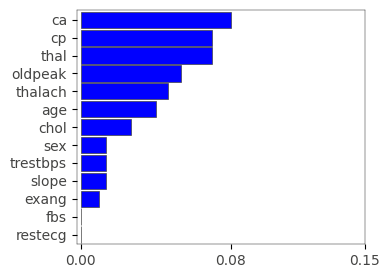

In [8]:
X=df.drop('num',axis=1)
y=df['num']
#creating baseline model
rf,oob=evalClass(X,y,150)
showimp(rf,X,y)

Mean OOB score: 0.8250825082508252
16,670 tree nodes and 12.0 median tree height
Data cleanning produced an improvment of 44.59224985540777
          Importance
Feature             
thal        0.059406
ca          0.049505
cp          0.039604
age         0.026403
chol        0.019802
oldpeak     0.019802
sex         0.013201
exang       0.013201
trestbps    0.009901
thalach     0.009901
slope       0.009901
restecg     0.003300
fbs         0.000000
ca_na       0.000000
thal_na     0.000000


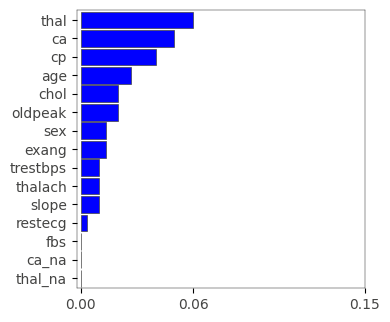

In [9]:
# try to improve results by feature engineering
#first, replace missing values (-1) with median()
Xclean=df.drop('num',axis=1)
normalize_num(Xclean,-1)
fix_missing_num(Xclean)
# now, according to the information provided with the dataset, target feature has values from 0 to 4
# but to predict if a pacient has heart disease we should have 2 categories only una for 0 and other for (1-4)
yclean=y.clip(0,1)
# let's see if cleaning helped to improve results
rf1,oob1=evalClass(Xclean,yclean,150)
print(f'Data cleanning produced an improvment of {oob1*100/oob-100}')
I=showimp(rf1,Xclean,y)
print(I)

Also tried to drop some features but no improvement was seen.

## Next step
Dataset is now cleaned and it looks good to be used to train, validate and test our models.The code related is in `clf_model_selection.ipynb`.

So now, before leaving this file, let's save dataset in to the table `class_clean_data` in the database.

In [10]:
# then let's put all features in a single dataframe and save it to database
df_clean=pd.concat([Xclean,yclean],axis=1)
df_clean.to_sql('class_clean_data', con, if_exists='replace',index=False)
#just to confirm clean dataset was successfuly saved
print(pd.read_sql_query('select name from sqlite_master where type="table" and name like "%class%"',con))
test=pd.read_sql_query('select * from class_clean_data',con).sample(1)
test

               name
0    class_raw_data
1  class_clean_data


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ca_na,thal_na,num
126,56,0,4,200,288,1,2,133,1,4.0,3,2.0,7.0,0,0,1


In [11]:
con.commit()
con.close()